In [39]:
# Use only the provided packages!
import math
import csv
import pandas as pd
import numpy as np

from collections import Counter
import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold

In [100]:
train = pd.read_csv("aluminum_coldRoll_train.csv")
test = pd.read_csv("aluminum_coldRoll_testNoY.csv")

In [5]:
for i in range(len(train.columns)):
    if type(train[train.columns[i]][0]) == str:
        le = LabelEncoder()
        le.fit(train[train.columns[i]])
        train[train.columns[i]] = le.transform(train[train.columns[i]])

In [6]:
train

,ID,alloy,cutTemp,rollTemp,firstPassRollPressure,secondPassRollPressure,topEdgeMicroChipping,blockSource,machineRestart,contourDefNdx,clearPassNdx,y_passXtremeDurability
0,1,2,2,2,500,350,0,2,0,5,2.013540,0
1,2,3,1,0,575,325,0,0,0,2,1.887291,1
2,3,6,2,1,450,350,0,1,0,2,2.016347,1
3,4,2,0,1,600,500,0,1,0,5,1.887250,0
4,5,5,1,1,525,425,0,0,0,5,2.156250,0
...,...,...,...,...,...,...,...,...,...,...,...,...
159995,159996,3,0,0,475,375,0,0,0,5,2.085409,0
159996,159997,7,2,1,600,350,2,1,0,4,1.958085,1
159997,159998,6,1,2,525,450,0,2,0,5,2.034765,0
159998,159999,9,2,0,575,400,0,2,0,2,2.061427,1


In [3]:
mask = train.columns[train.columns != "y_passXtremeDurability"]

In [27]:
X = train[mask]
X = X.drop(columns = "ID")
y = train["y_passXtremeDurability"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Preprocessing

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random

random.seed(42)

In [6]:
train = pd.read_csv("aluminum_coldRoll_train.csv")
final_test = pd.read_csv("aluminum_coldRoll_testNoY.csv")

In [7]:
data = train.drop(["ID","y_passXtremeDurability"], axis = 1)
label = train["y_passXtremeDurability"]
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.30, random_state = 123)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

In [9]:
for i in range(len(data.columns)):
    print(type(data[data.columns[i]][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.int64'>
<class 'numpy.float64'>


In [10]:
data.columns

Index(['alloy', 'cutTemp', 'rollTemp', 'firstPassRollPressure',
       'secondPassRollPressure', 'topEdgeMicroChipping', 'blockSource',
       'machineRestart', 'contourDefNdx', 'clearPassNdx'],
      dtype='object')

In [11]:
data

,alloy,cutTemp,rollTemp,firstPassRollPressure,secondPassRollPressure,topEdgeMicroChipping,blockSource,machineRestart,contourDefNdx,clearPassNdx
0,2224,med,med,500,350,no,MasterAlloys,no,5,2.013540
1,2324,low,high,575,325,no,Argon-Industries,no,2,1.887291
2,6063,med,low,450,350,no,L27,no,2,2.016347
3,2224,high,low,600,500,no,L27,no,5,1.887250
4,6061,low,low,525,425,no,Argon-Industries,no,5,2.156250
...,...,...,...,...,...,...,...,...,...,...
159995,2324,high,high,475,375,no,Argon-Industries,no,5,2.085409
159996,7055,med,low,600,350,yes,L27,no,4,1.958085
159997,6063,low,med,525,450,no,MasterAlloys,no,5,2.034765
159998,7075-T6,med,high,575,400,no,MasterAlloys,no,2,2.061427


In [12]:
# Create pipelines
numeric_features = ["firstPassRollPressure", "secondPassRollPressure", "contourDefNdx", "clearPassNdx"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["alloy", "cutTemp", "rollTemp", "topEdgeMicroChipping", "blockSource", "machineRestart"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [19]:
# Pipeline the training and test data
transformed_train = preprocessor.fit_transform(X_train)
transformed_test = preprocessor.transform(X_test)

- train test split
- decision tree
- logistic regression
- knn

# Decision Tree and Logistic Regression

Investigating depths...


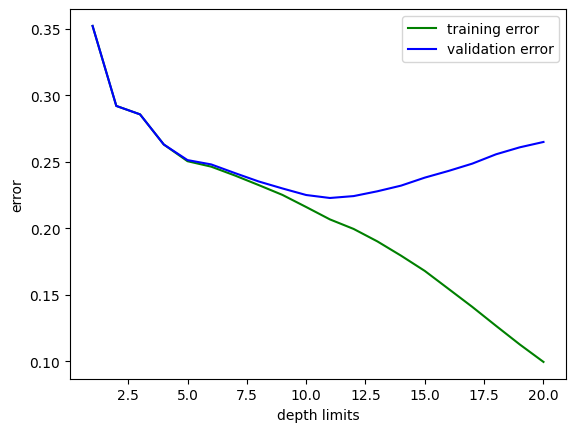

The best depth limit to use for this data is d = 11, with validation error 0.223.


In [10]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')
train_errors = []
val_errors = []

best_d = 0
best_score = 0
for d in range(1,21):
    dt = DecisionTreeClassifier(criterion = "entropy", max_depth = d)
    dt.fit(X,y)
    
    # training errors
    train_error = 1 - dt.score(X,y)
    train_errors.append(train_error)

    # validation errors using cross_val_score
    cross_vals = cross_val_score(dt, X, y, cv = 10)
    avg_cross_val = sum(cross_vals)/10
    val_errors.append(1 - avg_cross_val)

    if avg_cross_val > best_score:
        best_score = avg_cross_val
        best_d = d
    
plt.plot(range(1,21), train_errors, color = "green", label = "training error")
plt.plot(range(1,21), val_errors, color = "blue", label = "validation error")
plt.xlabel("depth limits")
plt.ylabel("error")
plt.legend()
plt.show();

print(f"The best depth limit to use for this data is d = {best_d}, with validation error {round(1 - best_score,3)}.")
### ========== TODO : END ========== ###

In [12]:
best_d

11

In [13]:
dt = DecisionTreeClassifier(criterion = "entropy", max_depth = best_d)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [38]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
for l in [0.00000000001, 0.1, 1, 10, 100]:
    print(f'Classifying using lambda = {l} for Logistic Regression')
    log_reg = LogisticRegression(C = 1/l, random_state = 0, solver = 'liblinear', max_iter = 1000)
    log_reg.fit(X, y)
    y_pred_log = log_reg.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred_log, normalize=True)
    print('\t-- training error: %.3f' % train_error)

Classifying using lambda = 1e-11 for Logistic Regression
	-- training error: 0.296
Classifying using lambda = 0.1 for Logistic Regression
	-- training error: 0.296
Classifying using lambda = 1 for Logistic Regression
	-- training error: 0.295
Classifying using lambda = 10 for Logistic Regression
	-- training error: 0.295
Classifying using lambda = 100 for Logistic Regression
	-- training error: 0.298


In [40]:
log_reg = LogisticRegression(C = 100, random_state = 0, solver = 'liblinear', max_iter = 1000)
log_reg.fit(X, y)

LogisticRegression(C=100, max_iter=1000, random_state=0, solver='liblinear')

In [41]:
predictions = log_reg.predict_proba(final_test)

In [42]:
data = {'ID': final_test["ID"],
        'y_passXtremeDurability': predictions}
df = pd.DataFrame(data)

In [44]:
df.to_csv('submission2.csv', index=False) 

# Neural Network

In [79]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network for binary classification.
    We train the network with a softmax output and cross entropy loss function
    with L2 regularization on the weight matrices. The network uses a ReLU
    nonlinearity after the first fully connected layer.
    Input: X
    Hidden states for layer 1: h1 = XW1 + b1
    Activations: a1 = ReLU(h1)
    Hidden states for layer 2: h2 = a1W2 + b2
    Probabilities: s = softmax(h2)

    ReLU function:
    (i) x = x if x >= 0  (ii) x = 0 if x < 0

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None

        ### ========== TODO : START ========== ###
        #   Calculate the output of the neural network using forward pass.
        #   The result should have (N, C), where N is the number of examples, and C is the number
        #   of classes.
        #   The output of the second fully connected layer is the output scores (before softmax).
        #   Do not use a for loop in your implementation.
        #   Please use 'h1' as input of hidden layers, and 'a1' as output of
        #   Refer to the comments at the beginning of this class for the model architecture
        #   You may simply use np.maximun for implementing ReLU.
        ##  Part (b): Implement the forward pass and compute scores.

        h1 = X.dot(W1) + b1
        a1 = np.maximum(0,h1)
        scores = a1.dot(W2) + b2

        ### ========== TODO : END ========== ###


        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None

        # scores is num_examples by num_classes (N, C)
        def softmax_loss(x, y):
            ### ========== TODO : START ========== ###
            #   Calculate the cross entropy loss after softmax output layer.
            #   This function should return loss and dx
            probs = np.exp(x - np.max(x, axis=1, keepdims=True))
            probs /= np.sum(probs, axis=1, keepdims=True)
            N = x.shape[0]

            ##  Part (d): Implement the CrossEntropyLoss
            loss = -(1/N) * np.sum(np.log(probs[np.arange(N), y]))
            ##  Part (d): Implement the gradient of y wrt x
            dx = probs.copy()
            dx[np.arange(N), y] -= 1
            dx /= N
            ### ========== TODO : END ========== ###
            return loss, dx


        data_loss, dscore = softmax_loss(scores, y)

        ### ========== TODO : START ========== ###
        #   Calculate the regularization loss. Multiply the regularization
        #   loss by 0.5 (in addition to the factor reg).
        ##  Part (c): Implement the regularization loss

        reg_loss = 0.5*reg*(np.sum(W1*W1) + np.sum(W2*W2))
        ### ========== TODO : END ========== ###

        loss = data_loss + reg_loss

        grads = {}

        ### ========== TODO : START ========== ###
        #  Compute backpropagation
        #  Remember the loss contains two parts: cross-entropy and regularization. The computation for gradients of W1 and b1 shown here can be regarded as a reference.
        ## Part (e): Implement the computations of gradients for W2 and b2.
        grads['W2'] = a1.T.dot(dscore) + reg * W2
        grads['b2'] = np.sum(dscore, axis = 0)

        dh = np.dot(dscore, W2.T)
        dh[a1 <= 0] = 0

        grads['W1'] = np.dot(X.T, dh) + reg * W1
        grads['b1'] = np.ones(N).dot(dh)
        ### ========== TODO : END ========== ###

        return loss, grads

    def train(self, X_1, y_1, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=20000, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X_1.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in np.arange(num_iters):
            X_batch = None
            y_batch = None

            #   Create a minibatch (X_batch, y_batch) by sampling batch_size
            #   samples randomly.

            b_index = np.random.choice(num_train, batch_size)
            X_batch = X_1[b_index]
            y_batch = y_1[b_index]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)


            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']


            if verbose and it % 100 == 0:
                print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ### ========== TODO : START ========== ###
        #   Predict the class given the input data.
        ##  Part (f): Implement the prediction function
        h1 = X.dot(self.params['W1']) + self.params['b1']
        a1 = np.maximum(0,h1)
        scores = a1.dot(self.params['W2']) + self.params['b2']

        y_pred = np.argmax(scores, axis = 1)
        ### ========== TODO : END ========== ###

        return y_pred

In [81]:
input_size = 576
hidden_size = 50
num_classes = 2
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
for learning_rate in [1e-5, 1e-4, 1e-3, 5e-3, 1e-1]:
  print('learning_rate: ', learning_rate)
  stats = net.train(X_train, y_train, X_test, y_test,
              num_iters=1000, batch_size=200,
              learning_rate=learning_rate, learning_rate_decay=0.95,
              reg=0.1, verbose=True)

  # Predict on the validation set
  val_acc = (net.predict(X_test) == y_test).mean()
  print('Validation accuracy: ', val_acc)

learning_rate:  1e-05


KeyError: "None of [Index([ 47326,  24436, 105117,  49581,  32958,  99313,  45489, 122982,  59495,\n       100756,\n       ...\n        62150, 122344,  30052,  29454,  88447,    294,  82160,  49449, 117574,\n        56048],\n      dtype='int64', length=200)] are in the [columns]"

# SVM

In [21]:
svm = SVC(probability = True)
svm.fit(transformed_train, y_train)

SVC(probability=True)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_svm = svm.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print("Metrics for SVM model:")
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Metrics for SVM model:
Accuracy: 0.78, Precision: 0.77, Recall: 0.75, F1 Score: 0.76


In [24]:
transformed_test = preprocessor.transform(final_test.drop("ID",axis = 1))

In [25]:
# one time using predict
test_ID = final_test["ID"]
#final_test = final_test.drop("ID",axis = 1)
test_pred = svm.predict(transformed_test)

In [26]:
data = {'ID': test_ID,
        'y_passXtremeDurability': test_pred}
df = pd.DataFrame(data)
df.to_csv('svm_submission.csv', index=False) 

In [27]:
# another time using predict_proba
test_pred_proba = svm.predict_proba(transformed_test)
data = {'ID': test_ID,
        'y_passXtremeDurability': test_pred_proba}
df = pd.DataFrame(data)
df.to_csv('svm_submission_proba.csv', index=False) 

ValueError: Per-column arrays must each be 1-dimensional

In [39]:
test_proba = np.zeros(160000)

for i in range(160000):

    if test_pred_proba[i,0] >= test_pred_proba[i,1]:
        test_proba[i] = 1 - test_pred_proba[i,0]

    else:
        test_proba[i] = test_pred_proba[i,1]

In [40]:
data = {'ID': test_ID,
        'y_passXtremeDurability': test_proba}
df = pd.DataFrame(data)
df.to_csv('svm_submission_proba2.csv', index=False) 

# XGBoost

In [16]:
model = xgb.XGBClassifier(n_estimators=150, learning_rate = 0.1, objective='binary:logistic', eval_metric='logloss', num_parallel_tree = 10)

In [17]:
model.fit(transformed_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=10, ...)

In [18]:
y_pred = model.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics for model:")
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Metrics for model:
Accuracy: 0.80, Precision: 0.78, Recall: 0.77, F1 Score: 0.77


In [19]:
transformed_test = preprocessor.transform(final_test.drop("ID",axis = 1))

In [20]:
test_ID = final_test["ID"]
#final_test = final_test.drop("ID",axis = 1)
test_pred = model.predict_proba(transformed_test)

In [19]:
test_proba = np.zeros(160000)

for i in range(160000):

    if test_pred[i,0] >= test_pred[i,1]:
        test_proba[i] = 1 - test_pred[i,0]

    else:
        test_proba[i] = test_pred[i,1]

In [20]:
data = {'ID': test_ID,
        'y_passXtremeDurability': test_proba}
df = pd.DataFrame(data)
df.to_csv('xgboost_submission.csv', index=False) 

# Cat Boost

In [108]:
X.nunique()

alloy                         11
cutTemp                        3
rollTemp                       3
firstPassRollPressure          9
secondPassRollPressure         9
topEdgeMicroChipping           3
blockSource                    3
machineRestart                 2
contourDefNdx                  5
clearPassNdx              160000
dtype: int64

In [106]:
train = pd.read_csv("aluminum_coldRoll_train.csv")
test = pd.read_csv("aluminum_coldRoll_testNoY.csv")

In [112]:
target = "y_passXtremeDurability"
X = train.drop(columns=[target, "ID"]).astype(str)

# cat_cols = X.columns[:-1].tolist()
# X.loc[:, cat_cols] = X.loc[:, cat_cols].astype(str)

test2 = test.drop(columns=["ID"]).astype(str)
#test2.loc[:, cat_cols] = test.loc[:, cat_cols].astype(str)
#X = X.astype("object")
y = train[target].astype(int)

cat_cols = X.columns.tolist() #X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_pred = np.zeros(len(train))
test_pred = np.zeros(len(test2))
best_its = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
    val_pool   = Pool(X_val, y_val, cat_features=cat_cols)
    test_pool  = Pool(test2,      cat_features=cat_cols)

    # 🔧 TUNED PARAMS
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",
        learning_rate=0.025,     # slightly smaller LR
        depth=5,                  # shallower trees (less overfit)
        iterations=3000,          # more rounds, early stopping will stop earlier
        l2_leaf_reg=6,            # stronger regularization
        random_seed=42 + fold,
        bagging_temperature=0.5,  # a bit more randomness
        od_type="Iter",
        od_wait=120,
        verbose=200,
        one_hot_max_size = 11
    )

    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    best_its.append(model.tree_count_)

    val_pred = model.predict_proba(val_pool)[:, 1]
    oof_pred[val_idx] = val_pred

    test_pred += model.predict_proba(test_pool)[:, 1] / n_splits

def clip(p):
    return np.clip(p, 1e-6, 1 - 1e-6)

cv_logloss = log_loss(y, clip(oof_pred))
print("\n===================================")
print(f"5-fold OOF LogLoss: {cv_logloss:.6f}")
print(f"Best iterations per fold: {best_its}")
print("===================================")

Categorical columns: ['alloy', 'cutTemp', 'rollTemp', 'firstPassRollPressure', 'secondPassRollPressure', 'topEdgeMicroChipping', 'blockSource', 'machineRestart', 'contourDefNdx', 'clearPassNdx']

===== Fold 1 =====
0:	learn: 0.6852118	test: 0.6852261	best: 0.6852261 (0)	total: 93.2ms	remaining: 4m 39s
200:	learn: 0.4573011	test: 0.4584181	best: 0.4584181 (200)	total: 13.4s	remaining: 3m 7s
400:	learn: 0.4340058	test: 0.4355446	best: 0.4355446 (400)	total: 26s	remaining: 2m 48s
600:	learn: 0.4258763	test: 0.4277297	best: 0.4277297 (600)	total: 36.8s	remaining: 2m 27s
800:	learn: 0.4225208	test: 0.4252551	best: 0.4252551 (800)	total: 46.7s	remaining: 2m 8s
1000:	learn: 0.4204908	test: 0.4244267	best: 0.4244260 (997)	total: 56.9s	remaining: 1m 53s
1200:	learn: 0.4189805	test: 0.4242012	best: 0.4242012 (1200)	total: 1m 7s	remaining: 1m 40s
1400:	learn: 0.4178277	test: 0.4241305	best: 0.4241184 (1310)	total: 1m 17s	remaining: 1m 27s
Stopped by overfitting detector  (120 iterations wait)

be

In [113]:
submission = pd.DataFrame({
    "ID": test["ID"],
    "y_passXtremeDurability": clip(test_pred)
})

submission.to_csv("catboost_cv_onehot_3.csv", index=False)